    Project Name: Weighted Rating System
    Project Type: Weighted Scores (Statistical Modeling)
    Author: Melvin Tai (Last Updated: July 2nd, 2025)

---

**Behind the Project Idea:**  
Have you ever had the experience of pressing "Sort by Rating" - may it be online shopping, food delivery, or even Kaggle datasets - and before you know it, you spend the next 20 minutes scrolling over products rated 5-stars by one guy? Well, it gets even better when you realize that guy probably is the seller themselves. 

We call these rating systems *naive*. These naive rating systems rank products solely by their mean score, which obviously and unfairly promotes items with very few perfect ratings while heavily penalizing well-established items with thousands of votes. This small-sample bias leads to inaccurate and unreliable rankings. Therefore, our goal is to develop a statistical algorithm that evaluates existing advanced rating systems, such as the Bayesian Average, Wilson Score Interval, Bradley–Terry–Luce, and Dirichlet–Multinomial models, to balance rating quality with vote count, thus producing fairer and more stable rankings.

---

**Project Description:**  
This project evaluates advanced weighted rating algorithms (i.e. Bayesian Average, Wilson Score Intervals, Bradley–Terry–Luce Model, and Dirichlet–Multinomial Model) to correct small-sample bias in average-based rating systems.

---

**Project Tools Selection:**  
Polars was chosen for this project due to its time- and memory-efficiency that exceeds Pandas for large datasets (although Pandas was still applied in the investigation below for in-depth statistical models), and compatibility with NumPy, SciPy, and Matplotlib for statistical modeling and data visualization would make things much easier for us.

---

### Task 1: Initialization and Null Values

In [4]:
import polars as pl
import math
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [5]:
# Reading all three datasets - note that we are only importing the necessary columns.
df_books = pl.read_csv("Books_Sales_and_Ratings_The_Devastator_Kaggle.csv", columns = ["Book Name", "Book_average_rating", "Book_ratings_count"])
df_games = pl.read_csv("Global_Video_Game_Sales_&_Ratings_The_Devastator_Kaggle.csv", columns = ["Name", "User_Score", "User_Count"], schema_overrides = {"User_Score": pl.Utf8})
df_reviews = pl.read_csv("Amazon_Reviews_Unlocked_Mobile_Phones_PromptCloud_Kaggle.csv", columns = ["Reviews", "Rating", "Review Votes"])

# Reordering "df_reviews" for the convenience of data preparation.
df_reviews = df_reviews.select([df_reviews.columns[1], df_reviews.columns[0], df_reviews.columns[2]])

# Renaming each column of each dataset to standardize all column names.
df_books = df_books.rename({df_books.columns[0]: "Identifier", df_books.columns[1]: "Rated", df_books.columns[2]: "Votes"})
df_games = df_games.rename({df_games.columns[0]: "Identifier", df_games.columns[1]: "Rated", df_games.columns[2]: "Votes"})
df_reviews = df_reviews.rename({df_reviews.columns[0]: "Identifier", df_reviews.columns[1]: "Rated", df_reviews.columns[2]: "Votes"})

# Printing the first five rows of each dataset.
print('Dataset 1: "df_books" (Books_Sales_and_Ratings_The_Devastator_Kaggle.csv),', df_books)
print('Dataset 2: "df_games" (Global_Video_Game_Sales_&_Ratings_The_Devastator_Kaggle.csv),', df_games)
print('Dataset 3: "df_reviews" (Amazon_Reviews_Unlocked_Mobile_Phones_PromptCloud_Kaggle.csv),', df_reviews)

Dataset 1: "df_books" (Books_Sales_and_Ratings_The_Devastator_Kaggle.csv), shape: (1_070, 3)
┌─────────────────────────────────┬───────┬────────┐
│ Identifier                      ┆ Rated ┆ Votes  │
│ ---                             ┆ ---   ┆ ---    │
│ str                             ┆ f64   ┆ i64    │
╞═════════════════════════════════╪═══════╪════════╡
│ Beowulf                         ┆ 3.42  ┆ 155903 │
│ Batman: Year One                ┆ 4.23  ┆ 145267 │
│ Go Set a Watchman               ┆ 3.31  ┆ 138669 │
│ When You Are Engulfed in Flame… ┆ 4.04  ┆ 150898 │
│ Daughter of Smoke & Bone        ┆ 4.04  ┆ 198283 │
│ …                               ┆ …     ┆ …      │
│ Gray Mountain                   ┆ 3.52  ┆ 37379  │
│ The Power of One                ┆ 4.34  ┆ 57312  │
│ The Maltese Falcon              ┆ 3.92  ┆ 58742  │
│ Night Road                      ┆ 4.17  ┆ 58028  │
│ Tripwire                        ┆ 4.07  ┆ 55251  │
└─────────────────────────────────┴───────┴────────┘
Datase

#### Task 1.1: Introduction to "df_books" and removing 'null' values

"df_books" is a 1,071 row, 15 column (158 KB) dataset titled "Books Sales and Ratings", authored by The Devastator and acquired via Kaggle. From my (Melvin's) selection of three datasets, "df_books" served as the small, simple, and fundamental dataset that was used for 'confirming' purposes. Every task had to pass this dataset before moving on to the next two. It was also the easiest and more dependable one to handle, and due to its small size, working on data visualization did not take me as long as I had expected.

In [8]:
# Are there any 'null' values in "df_books"? 
df_books.describe()

statistic,Identifier,Rated,Votes
str,str,f64,f64
"""count""","""1047""",1070.0,1070.0
"""null_count""","""23""",0.0,0.0
"""mean""",null,4.007,94909.913084
"""std""",null,0.247244,31513.242518
"""min""",""" A Monster Calls """,2.97,27308.0
"""25%""",null,3.85,70382.0
"""50%""",null,4.02,89356.0
"""75%""",null,4.17,113915.0
"""max""","""é€²æ’ƒã®å·¨äºº 1""",4.77,206792.0


In [9]:
# "df_books" does not seem to have any 'null' values in "Rated or "Votes".
# However, just in case, let us fill up the 23 missing "Identifier" values with "Unnamed"!
df_books = df_books.with_columns(pl.col("Identifier").fill_null("Unnamed"))
df_books.describe()

statistic,Identifier,Rated,Votes
str,str,f64,f64
"""count""","""1070""",1070.0,1070.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,4.007,94909.913084
"""std""",null,0.247244,31513.242518
"""min""",""" A Monster Calls """,2.97,27308.0
"""25%""",null,3.85,70382.0
"""50%""",null,4.02,89356.0
"""75%""",null,4.17,113915.0
"""max""","""é€²æ’ƒã®å·¨äºº 1""",4.77,206792.0


#### Task 1.2: Introduction to "df_games" and removing 'null' values

"df_games" is a 16,720 row, 16 column (1.54 MB) dataset titled "Global Video Game Sales & Ratings" (Raw Data.csv), authored by The Devastator and acquired via Kaggle. From my (Melvin's) selection of three datasets, "df_games" serves as the 'showcase' dataset - showcasing my findings and my use of techniques. As we are using the raw data document, there is a need for more in-depth data cleaning than other datasets, and as this dataset is also slightly larger than the "df_books", it is used to display our findings.

In [12]:
# You might have noticed above that the datatype for the "Rated" column of "df_games" is 'str' (string).
# As we imported the file, we found 'null' and "tbd" values in that column, which are not type 'f64' (float).
# And therefore we could only import the file by converting the whole column's datatype to 'str' (string).
# So, how many 'null' and "tbd" values do we have here?
df_games.describe()

statistic,Identifier,Rated,Votes
str,str,str,f64
"""count""","""16717""","""10015""",7590.0
"""null_count""","""2""","""6704""",9129.0
"""mean""",null,null,162.229908
"""std""",null,null,561.282326
"""min""",""" Beyblade Burst""","""0""",4.0
"""25%""",null,null,10.0
"""50%""",null,null,24.0
"""75%""",null,null,81.0
"""max""","""¡Shin Chan Flipa en colores!""","""tbd""",10665.0


A shocking 6704 'null' values from "Rated" and 9129 from "Votes". 

Now, we should replace the 'null' and "tbd" values with either the mean or median of "Rated"... but wait, "df_games" only has 16719 rows. If we use the mean or the median to replace at least 9129 'null' values from "Votes" alone (assuming all 6704 'null' values and hidden "tbd" values from "Votes" overlap), over half of this dataset will share the same value, and it would not pass the data cleaning process! Unfortunately, we can only choose to remove all 'null' and "tbd" values.

In [14]:
# Filtering all 'null' and "tbd" values from "Rated", and all 'null' values from "Votes".
df_games = (
    df_games
    .filter(
        (pl.col("Identifier").is_not_null()) & 
        (pl.col("Rated").is_not_null()) & 
        (pl.col("Rated") != "tbd") & 
        (pl.col("Votes").is_not_null())
    )
    .with_columns([
        pl.col("Rated").cast(pl.Float64).alias("Rated"),
        pl.col("Votes").cast(pl.Int64).alias("Votes")
    ])
)

# There are also two 'null' values in "Identifier" that we can conveniently name.
df_games = df_games.with_columns(pl.col("Identifier").fill_null("Unnamed"))

# Another issue we see is that "Rated" is on a scale of 0 - 10, unlike the other two datasets, which are 0 - 5.
# However, this can be easily solved by cutting all "Rated" values by half.
df_games = df_games.with_columns((pl.col("Rated").cast(pl.Float64) / 2).alias("Rated"))

# Ensuring our changes took place.
df_games.describe()

statistic,Identifier,Rated,Votes
str,str,f64,f64
"""count""","""7590""",7590.0,7590.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,3.562523,162.229908
"""std""",null,0.750003,561.282326
"""min""",""" Tales of Xillia 2""",0.0,4.0
"""25%""",null,3.2,10.0
"""50%""",null,3.75,24.0
"""75%""",null,4.1,81.0
"""max""","""uDraw Studio: Instant Artist""",4.85,10665.0


#### Task 1.3: Introduction to "df_reviews" and removing 'null' values

"df_reviews" is a 413,841 row, 6 column (125 MB) dataset titled "Amazon Reviews: Unlocked Mobile Phones", authored by PromptCloud and acquired via Kaggle. Unlike the others, this dataset refers to customer reviews after the purchase of some phone product on Amazon (and not product ratings). "Rated" refers to the customers' appraisal, while "Votes" refer to ratings of the appraisal, i.e. people who may or may not have purchased the same product, but found the customers' ratings to be truthful. From my (Melvin's) selection of three datasets, "df_reviews" serves as the 'verification' dataset, proving that this project can be integrated to larger datasets of completely different uses.

In [17]:
# Are there any 'null' values in "df_reviews"? 
df_reviews.describe()

statistic,Identifier,Rated,Votes
str,str,f64,f64
"""count""","""413778""",413840.0,401544.0
"""null_count""","""62""",0.0,12296.0
"""mean""",null,3.819578,1.507237
"""std""",null,1.548216,9.163853
"""min""","""! am very satisfied with this …",1.0,0.0
"""25%""",null,3.0,0.0
"""50%""",null,5.0,0.0
"""75%""",null,5.0,1.0
"""max""","""🤗""",5.0,645.0


In [18]:
# We see that "df_reviews" has 62 missing "Identifier" values and 12296 missing "Votes"!
# However, we do not have to remove all 'null' values this time.
# Given the scale of this dataset, we can simply replace 'null' values with the column mean or median.
# To make this decision, we can apply the Kurtosis formula.
kurtosis = stats.kurtosis(df_reviews["Votes"])

# If Kurtosis > 0, the dataset has a high tendency to have outliers, and we may use the median.
# Otherwise, if Kurtosis < 0, the dataset has a low tendency of having outliers, and we will use the mean. 
print(f'Our kurtosis value is a shocking {kurtosis:.2f}! This means there is a very high tendency of outliers in this dataset - median it is!')

Our kurtosis value is a shocking nan! This means there is a very high tendency of outliers in this dataset - median it is!


In [19]:
# Calculating the median of "Votes" of "df_reviews".
reviews_median = df_reviews.select(pl.col("Votes").median()).item()
df_reviews = df_reviews.with_columns(pl.col("Votes").fill_null(reviews_median).cast(pl.Int64))

# We can also conveniently replace the 62 missing "Tdentifier" values with "Unnamed".
df_reviews = df_reviews.with_columns(pl.col("Identifier").fill_null("Unnamed"))

# Let's see if we replaced the 'null' values correctly.
df_reviews.describe()

statistic,Identifier,Rated,Votes
str,str,f64,f64
"""count""","""413840""",413840.0,413840.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,3.819578,1.462454
"""std""",null,1.548216,9.030315
"""min""","""! am very satisfied with this …",1.0,0.0
"""25%""",null,3.0,0.0
"""50%""",null,5.0,0.0
"""75%""",null,5.0,1.0
"""max""","""🤗""",5.0,645.0


### Task 2: Abnormalities and Outliers

In [21]:
df_books_t2 = df_books
df_games_t2 = df_games
df_reviews_t2 = df_reviews

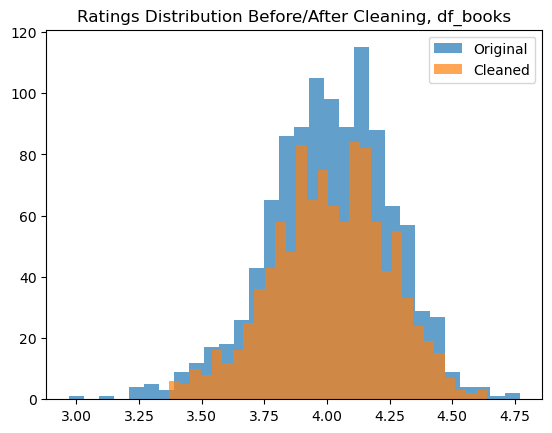

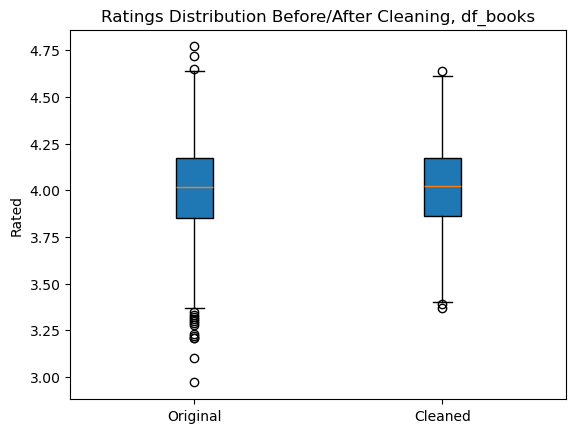

In [22]:
# Constructing a function to remove outliers using the Interquartile Range method.
def detect_outliers(df, column = "Rated"):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df.filter((pl.col(column) >= lower) & (pl.col(column) <= upper))

# Applying the function above to our datasets.
df_books_t2 = detect_outliers(df_books_t2, "Rated")
df_games_t2 = detect_outliers(df_games_t2, "Rated")
df_reviews_t2 = detect_outliers(df_reviews_t2, "Rated")

# Constructing a histogram to visualize the differences between the original and cleaned data.
plt.title("Ratings Distribution Before/After Cleaning, df_books")
plt.hist(df_books["Rated"], bins = 30, alpha = 0.7, label = "Original")
plt.hist(df_books_t2["Rated"], bins = 30, alpha = 0.7, label = "Cleaned")
plt.legend()
plt.show()

# Constructing a boxplot to visualize the differences between the original and cleaned data.
plt.title("Ratings Distribution Before/After Cleaning, df_books")
plt.boxplot([df_books["Rated"].to_pandas(), df_books_t2["Rated"].to_pandas()], labels = ["Original", "Cleaned"], patch_artist = True)
plt.ylabel("Rated")
plt.show()

In [23]:
df_books = df_books_t2
df_games = df_games_t2
df_reviews = df_reviews_t2

### Task 3: Pre-Investigation Statistical Modelling

##### Task 3.1: Pairwise Plots

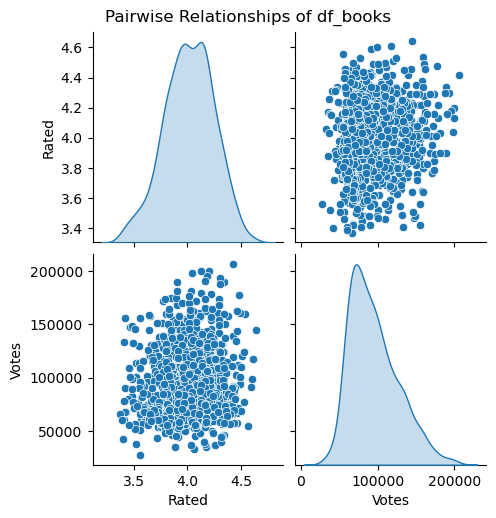

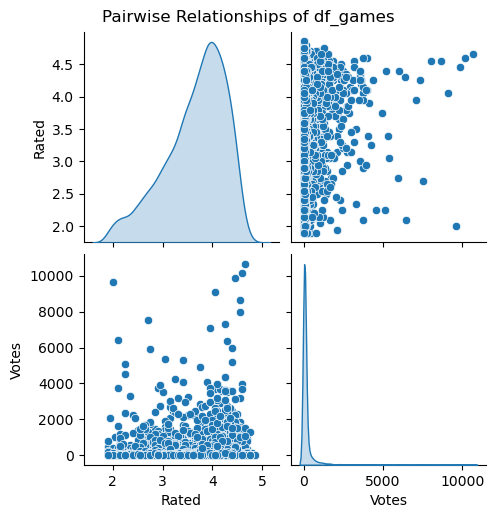

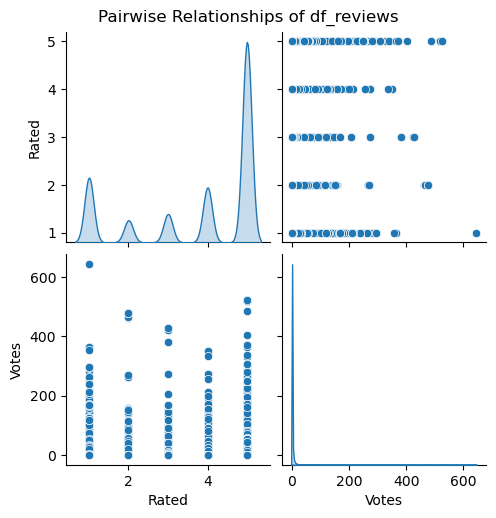

In [26]:
# Constructing a function to create pairwise plots.
def pairwise_plot(df, name):
    sns.pairplot(df.to_pandas()[["Rated", "Votes"]], diag_kind = "kde")
    plt.suptitle(f"Pairwise Relationships of {name}", y = 1.02)
    plt.show()

# Apply to each dataset.
pairwise_plot(df_books, "df_books")
pairwise_plot(df_games, "df_games")
pairwise_plot(df_reviews, "df_reviews")

##### Task 3.2: Scatter Plots (with K-Means Clustering)

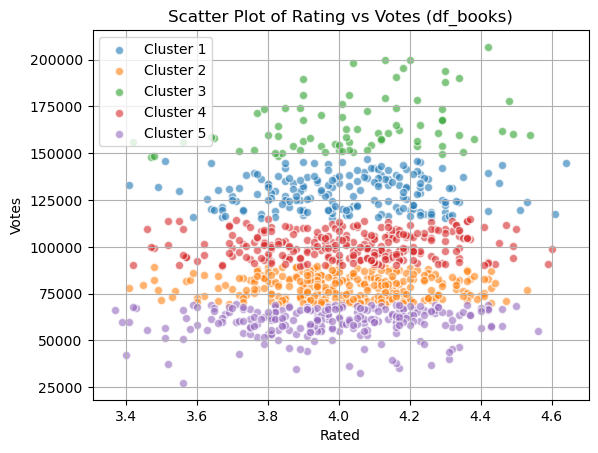

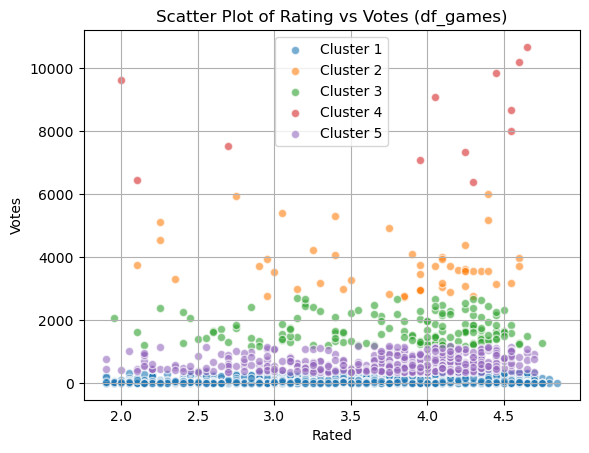

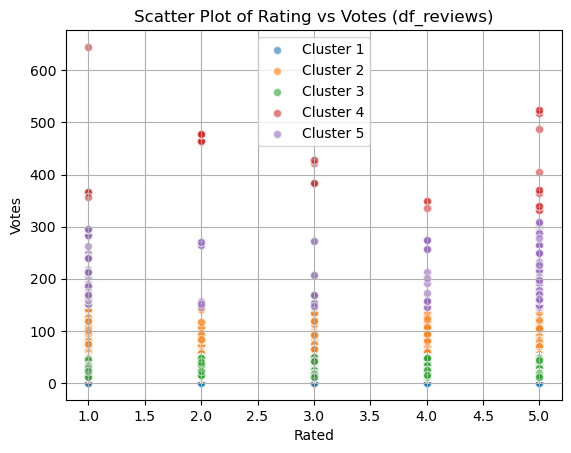

In [28]:
# Constructing a function to create scatter plots with K-Means clustering.
def make_scatterplots(df, name):
    X = np.column_stack((df["Rated"].to_numpy(), df["Votes"].to_numpy()))
    kmeans = KMeans(n_clusters = 5, random_state = 42)
    clusters = kmeans.fit_predict(X)
    for cluster in range(5):
        plt.scatter(
            X[clusters == cluster, 0], 
            X[clusters == cluster, 1], 
            label = f"Cluster {cluster + 1}",
            alpha = 0.6, edgecolors = 'w')
    plt.xlabel("Rated")
    plt.ylabel("Votes")
    plt.title(f"Scatter Plot of Rating vs Votes ({name})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Apply to each dataset.
make_scatterplots(df_books, "df_books")
make_scatterplots(df_games, "df_games")
make_scatterplots(df_reviews, "df_reviews")

### Task 4: Weighted Rating Algorithms

##### Task 4.1: Bayesian Average (Weighted Rating Formula)

The Bayesian Average balances each product’s mean rating with the global mean, weighted by vote count. This prevents low-vote products from dominating rankings. IMDB uses this method for their Top 250 movies list.

In [32]:
# Constructing a function to calculate the Bayesian Average of a dataset and adding it to a new column.
def bayesian_avg(df, m = 50):
    mean = df["Rated"].mean()
    votes_column = pl.col("Votes")
    return df.with_columns(((votes_column / (votes_column + m)) * pl.col("Rated") + (m / (votes_column + m)) * mean).alias("Bayesian_Score"))

# Applying the function above to our datasets.
df_books = bayesian_avg(df_books)
df_games = bayesian_avg(df_games)
df_reviews = bayesian_avg(df_reviews)

# Printing all three datasets.
for dataset in [df_books, df_games, df_reviews]:
    print(dataset.head())

shape: (5, 4)
┌─────────────────────────────────┬───────┬────────┬────────────────┐
│ Identifier                      ┆ Rated ┆ Votes  ┆ Bayesian_Score │
│ ---                             ┆ ---   ┆ ---    ┆ ---            │
│ str                             ┆ f64   ┆ i64    ┆ f64            │
╞═════════════════════════════════╪═══════╪════════╪════════════════╡
│ Beowulf                         ┆ 3.42  ┆ 155903 ┆ 3.420191       │
│ Batman: Year One                ┆ 4.23  ┆ 145267 ┆ 4.229926       │
│ When You Are Engulfed in Flame… ┆ 4.04  ┆ 150898 ┆ 4.039992       │
│ Daughter of Smoke & Bone        ┆ 4.04  ┆ 198283 ┆ 4.039994       │
│ Red Queen                       ┆ 4.08  ┆ 83354  ┆ 4.079961       │
└─────────────────────────────────┴───────┴────────┴────────────────┘
shape: (5, 4)
┌───────────────────────┬───────┬───────┬────────────────┐
│ Identifier            ┆ Rated ┆ Votes ┆ Bayesian_Score │
│ ---                   ┆ ---   ┆ ---   ┆ ---            │
│ str                   ┆

##### Task 4.2: Wilson Score Interval

The Wilson score provides a conservative confidence interval estimate of a product’s true rating, prioritizing reliability. It reduces the rank of items with too few votes.

In [35]:
# Constructing a function to calculate the Wilson Score Interval of a dataset and adding it to a new column.
def wilson(rating, votes, z = 1.96, max_rating = 5):
    if votes == 0 or rating is None or votes is None:
        return 0.0
    phat = rating / max_rating
    numerator = phat + z * z / (2 * votes) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * votes)) / votes)
    denominator = 1 + z * z / votes
    return numerator / denominator * max_rating

def apply_WSI(df):
    return df.with_columns(
        pl.struct(["Rated", "Votes"]).map_elements(
            lambda x: wilson(float(x["Rated"]), float(x["Votes"])), return_dtype = pl.Float64
        ).alias("Wilson_Score")
    )

# Applying the function above to our datasets.
df_books = apply_WSI(df_books)
df_games = apply_WSI(df_games)
df_reviews = apply_WSI(df_reviews)

# Printing all three datasets.
for dataset in [df_books, df_games, df_reviews]:
    print(dataset.head())

shape: (5, 5)
┌─────────────────────────────────┬───────┬────────┬────────────────┬──────────────┐
│ Identifier                      ┆ Rated ┆ Votes  ┆ Bayesian_Score ┆ Wilson_Score │
│ ---                             ┆ ---   ┆ ---    ┆ ---            ┆ ---          │
│ str                             ┆ f64   ┆ i64    ┆ f64            ┆ f64          │
╞═════════════════════════════════╪═══════╪════════╪════════════════╪══════════════╡
│ Beowulf                         ┆ 3.42  ┆ 155903 ┆ 3.420191       ┆ 3.408438     │
│ Batman: Year One                ┆ 4.23  ┆ 145267 ┆ 4.229926       ┆ 4.220673     │
│ When You Are Engulfed in Flame… ┆ 4.04  ┆ 150898 ┆ 4.039992       ┆ 4.030024     │
│ Daughter of Smoke & Bone        ┆ 4.04  ┆ 198283 ┆ 4.039994       ┆ 4.031302     │
│ Red Queen                       ┆ 4.08  ┆ 83354  ┆ 4.079961       ┆ 4.066775     │
└─────────────────────────────────┴───────┴────────┴────────────────┴──────────────┘
shape: (5, 5)
┌───────────────────────┬───────┬────

##### Task 4.3: Bradley–Terry–Luce Model

The BTL model (scaled to 0-5) estimates the probability of one item being preferred over another based on pairwise comparisons (thus widely used in ranking and preference modeling).

In [38]:
# Constructing a function to calculate the BTL score of a dataset and adding it to a new column.
def bradley_terry_luce(df):
    raw_score = pl.col("Rated") / pl.col("Rated").sum()
    scaled_score = (raw_score / raw_score.max() * 5).alias("BTL_Score")
    return df.with_columns(scaled_score)

# Applying the function above to our datasets.
df_books = bradley_terry_luce(df_books)
df_games = bradley_terry_luce(df_games)
df_reviews = bradley_terry_luce(df_reviews)

# Printing all three datasets.
for dataset in [df_books, df_games, df_reviews]:
    print(dataset.head())

shape: (5, 6)
┌─────────────────────────────────┬───────┬────────┬────────────────┬──────────────┬───────────┐
│ Identifier                      ┆ Rated ┆ Votes  ┆ Bayesian_Score ┆ Wilson_Score ┆ BTL_Score │
│ ---                             ┆ ---   ┆ ---    ┆ ---            ┆ ---          ┆ ---       │
│ str                             ┆ f64   ┆ i64    ┆ f64            ┆ f64          ┆ f64       │
╞═════════════════════════════════╪═══════╪════════╪════════════════╪══════════════╪═══════════╡
│ Beowulf                         ┆ 3.42  ┆ 155903 ┆ 3.420191       ┆ 3.408438     ┆ 3.685345  │
│ Batman: Year One                ┆ 4.23  ┆ 145267 ┆ 4.229926       ┆ 4.220673     ┆ 4.55819   │
│ When You Are Engulfed in Flame… ┆ 4.04  ┆ 150898 ┆ 4.039992       ┆ 4.030024     ┆ 4.353448  │
│ Daughter of Smoke & Bone        ┆ 4.04  ┆ 198283 ┆ 4.039994       ┆ 4.031302     ┆ 4.353448  │
│ Red Queen                       ┆ 4.08  ┆ 83354  ┆ 4.079961       ┆ 4.066775     ┆ 4.396552  │
└───────────────

##### Task 4.4: Dirichlet–Multinomial Model

The Dirichlet–Multinomial accounts for uncertainty in multinomial ratings (1–5 stars), providing a probabilistic model that avoids overconfidence when data is sparse.

In [41]:
# Constructing a function to calculate the Dirichlet Multinomial score of a dataset and adding it to a new column.
def dirichlet_multinomial(df, alpha = 1):
    return df.with_columns(((pl.col("Rated") * pl.col("Votes") + alpha) / (pl.col("Votes") + 5 * alpha)).alias("DM_Score"))

# Applying the function above to our datasets.
df_books = dirichlet_multinomial(df_books)
df_games = dirichlet_multinomial(df_games)
df_reviews = dirichlet_multinomial(df_reviews)

# Printing all three datasets.
for dataset in [df_books, df_games, df_reviews]:
    print(dataset.head())

shape: (5, 7)
┌─────────────────────────────────┬───────┬────────┬────────────────┬──────────────┬───────────┬──────────┐
│ Identifier                      ┆ Rated ┆ Votes  ┆ Bayesian_Score ┆ Wilson_Score ┆ BTL_Score ┆ DM_Score │
│ ---                             ┆ ---   ┆ ---    ┆ ---            ┆ ---          ┆ ---       ┆ ---      │
│ str                             ┆ f64   ┆ i64    ┆ f64            ┆ f64          ┆ f64       ┆ f64      │
╞═════════════════════════════════╪═══════╪════════╪════════════════╪══════════════╪═══════════╪══════════╡
│ Beowulf                         ┆ 3.42  ┆ 155903 ┆ 3.420191       ┆ 3.408438     ┆ 3.685345  ┆ 3.419897 │
│ Batman: Year One                ┆ 4.23  ┆ 145267 ┆ 4.229926       ┆ 4.220673     ┆ 4.55819   ┆ 4.229861 │
│ When You Are Engulfed in Flame… ┆ 4.04  ┆ 150898 ┆ 4.039992       ┆ 4.030024     ┆ 4.353448  ┆ 4.039873 │
│ Daughter of Smoke & Bone        ┆ 4.04  ┆ 198283 ┆ 4.039994       ┆ 4.031302     ┆ 4.353448  ┆ 4.039903 │
│ Red Queen   

### Task 5: Observations and Methodology Evaluation

- **Bayesian Average**
  - Pros:
    - Simplicity - simple to compute and highly interpretable.
    - Stability - ratings of low-vote items are shrunk closer to the global mean.
    - Credibility - works well in most context (IMDB uses this algorithm for their rankings).
 
- **Wilson Score Interval**
  - Pros:
    - Provides a conservative, confidence-based estimate of true product quality.
    - Reduces influence of low-vote outliers.
  - Cons:
    - Rate of Growth - mid-range ratings in the 3–4 star range do not offer enough details.
    - Extreme Qualities - strong at identifying highly and frequently rated products, while other products are penalized more aggressively.

- **Bradley–Terry–Luce (BTL)**
  - Pros:
    - Relativity - captures relative preferences between items.
    - Data Usage - ideal when a decent amount of comparison data is available.
  - Cons:
    - Scaling - our adaptation is scaled approximately between 0-5, and lacks detail.
    - Distortion - may distort rankings for highly skewed datasets.

- **Dirichlet–Multinomial**
  - Pros:
    - Uncertainty - accounts for the uncertainty in sparse ratings.
    - Rounding - smoothens extreme ratings and reduces overconfidence in items with lower votes.
  - Cons:
    - Unfitting - may not fit skewed real-world distributions well.
    - Complexity - less easily interpretable for non-technical parties.
  - Observations:
    - Leniency - low-vote products performs well, but exceptional products may be under-ranked.
    

**Key Findings:**
- Unfortunately, we did not find a single method that perfectly solves the small-sample bias problem.
- The Bayesian Average is the most interpretable, while the Wilson Score Interval is the most conservative.
- BTL and Dirichlet–Multinomial models provide comparative insights but require careful parameter tuning and/or additional data.
- We need a Weighted Rating System algorithm that combines interpretability, robustness, and fairness to balance vote count, average rating, and distribution skewness.

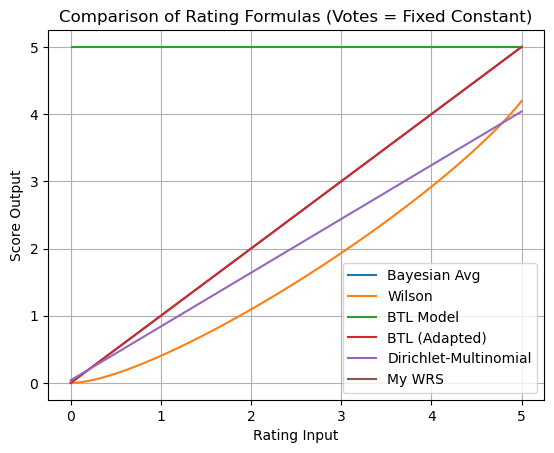

In [122]:
# Making an adapted version of BTL where "Votes" does not dominate.
def bradley_terry_luce_adapted(rating, max_rating = 5):
    if rating <= 0:
        return 0
    return (rating / max_rating) * 5

# Creating a constant of 20 "Votes" per rating.
votes = 20

# "Rated" values scale from 0.00, 0.01, 0.02, ..., 4.99, and 5.00.
ratings = np.arange(0, 5.01, 0.01)

# Creating lists and variables.
bayes_vals = []
wilson_vals = []
btl_vals = []
btl_vals_adpt = []
dm_vals = []
wrs_vals = []

# Looping through the datasets.
for r in ratings:
    df = pl.DataFrame({"Rated":[r], "Votes":[votes]})
    bayes_vals.append(bayesian_avg(df)["Bayesian_Score"][0])
    wilson_vals.append(wilson(r, votes))
    btl_vals.append(bradley_terry_luce(df)["BTL_Score"][0])
    btl_vals_adpt.append(bradley_terry_luce_adapted(r))
    dm_vals.append(dirichlet_multinomial(df)["DM_Score"][0])
    wrs_vals.append(my_wrs(df)["My_WRS"][0])

# Plotting the graph.
plt.title("Comparison of Rating Formulas (Votes = Fixed Constant)")
plt.plot(ratings, bayes_vals, label = "Bayesian Avg")
plt.plot(ratings, wilson_vals, label = "Wilson")
plt.plot(ratings, btl_vals, label = "BTL Model")
plt.plot(ratings, btl_vals_adpt, label = "BTL (Adapted)")
plt.plot(ratings, dm_vals, label = "Dirichlet-Multinomial")
plt.plot(ratings, wrs_vals, label = "My WRS")
plt.xlabel("Rating Input")
plt.ylabel("Score Output")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
for dataset in [df_books, df_games, df_reviews]:
    print(dataset.describe())

shape: (9, 8)
┌────────────┬───────────────────┬──────────┬──────────────┬────────────────┬──────────────┬───────────┬──────────┐
│ statistic  ┆ Identifier        ┆ Rated    ┆ Votes        ┆ Bayesian_Score ┆ Wilson_Score ┆ BTL_Score ┆ DM_Score │
│ ---        ┆ ---               ┆ ---      ┆ ---          ┆ ---            ┆ ---          ┆ ---       ┆ ---      │
│ str        ┆ str               ┆ f64      ┆ f64          ┆ f64            ┆ f64          ┆ f64       ┆ f64      │
╞════════════╪═══════════════════╪══════════╪══════════════╪════════════════╪══════════════╪═══════════╪══════════╡
│ count      ┆ 1054              ┆ 1054.0   ┆ 1054.0       ┆ 1054.0         ┆ 1054.0       ┆ 1054.0    ┆ 1054.0   │
│ null_count ┆ 0                 ┆ 0.0      ┆ 0.0          ┆ 0.0            ┆ 0.0          ┆ 0.0       ┆ 0.0      │
│ mean       ┆ null              ┆ 4.01445  ┆ 95112.439279 ┆ 4.014453       ┆ 4.001353     ┆ 4.325916  ┆ 4.014227 │
│ std        ┆ null              ┆ 0.230618 ┆ 31579.905784

### Task 6: Creating my own Weighted Rating System

To show my understanding of what we have done for this project and what I have learnt from it, I will create my own weighted rating system.

In [47]:
# Constructing a function to calculate my weighted rating system formula of a dataset and adding it to a new column.
def my_wrs(df, alpha = 0.1, scale_max = 5):
    skewness = stats.skew(df["Rated"].to_numpy())
    wrs_expr = ((pl.col("Rated") * np.log1p(pl.col("Votes"))) / (1 + alpha * abs(skewness)))
    wrs_scaled = (wrs_expr / wrs_expr.max() * scale_max).alias("My_WRS")
    return df.with_columns(wrs_scaled)

# Applying the function above to our datasets.
df_books = my_wrs(df_books)
df_games = my_wrs(df_games)
df_reviews = my_wrs(df_reviews)

# Printing all three datasets.
for dataset in [df_books, df_games, df_reviews]:
    print(dataset)

shape: (1_054, 8)
┌─────────────────────────────────┬───────┬────────┬────────────────┬──────────────┬───────────┬──────────┬──────────┐
│ Identifier                      ┆ Rated ┆ Votes  ┆ Bayesian_Score ┆ Wilson_Score ┆ BTL_Score ┆ DM_Score ┆ My_WRS   │
│ ---                             ┆ ---   ┆ ---    ┆ ---            ┆ ---          ┆ ---       ┆ ---      ┆ ---      │
│ str                             ┆ f64   ┆ i64    ┆ f64            ┆ f64          ┆ f64       ┆ f64      ┆ f64      │
╞═════════════════════════════════╪═══════╪════════╪════════════════╪══════════════╪═══════════╪══════════╪══════════╡
│ Beowulf                         ┆ 3.42  ┆ 155903 ┆ 3.420191       ┆ 3.408438     ┆ 3.685345  ┆ 3.419897 ┆ 3.70821  │
│ Batman: Year One                ┆ 4.23  ┆ 145267 ┆ 4.229926       ┆ 4.220673     ┆ 4.55819   ┆ 4.229861 ┆ 4.559366 │
│ When You Are Engulfed in Flame… ┆ 4.04  ┆ 150898 ┆ 4.039992       ┆ 4.030024     ┆ 4.353448  ┆ 4.039873 ┆ 4.368505 │
│ Daughter of Smoke & Bone    

In [48]:
# For further analysis.
for dataset in [df_books, df_games, df_reviews]:
    print(dataset.describe())

shape: (9, 9)
┌────────────┬───────────────────┬──────────┬──────────────┬───┬──────────────┬───────────┬──────────┬──────────┐
│ statistic  ┆ Identifier        ┆ Rated    ┆ Votes        ┆ … ┆ Wilson_Score ┆ BTL_Score ┆ DM_Score ┆ My_WRS   │
│ ---        ┆ ---               ┆ ---      ┆ ---          ┆   ┆ ---          ┆ ---       ┆ ---      ┆ ---      │
│ str        ┆ str               ┆ f64      ┆ f64          ┆   ┆ f64          ┆ f64       ┆ f64      ┆ f64      │
╞════════════╪═══════════════════╪══════════╪══════════════╪═══╪══════════════╪═══════════╪══════════╪══════════╡
│ count      ┆ 1054              ┆ 1054.0   ┆ 1054.0       ┆ … ┆ 1054.0       ┆ 1054.0    ┆ 1054.0   ┆ 1054.0   │
│ null_count ┆ 0                 ┆ 0.0      ┆ 0.0          ┆ … ┆ 0.0          ┆ 0.0       ┆ 0.0      ┆ 0.0      │
│ mean       ┆ null              ┆ 4.01445  ┆ 95112.439279 ┆ … ┆ 4.001353     ┆ 4.325916  ┆ 4.014227 ┆ 4.154035 │
│ std        ┆ null              ┆ 0.230618 ┆ 31579.905784 ┆ … ┆ 0.231967 

### Task 7: Post-Investigation Statistical Modelling

##### Task 7.1: Histograms with Normal Distribution

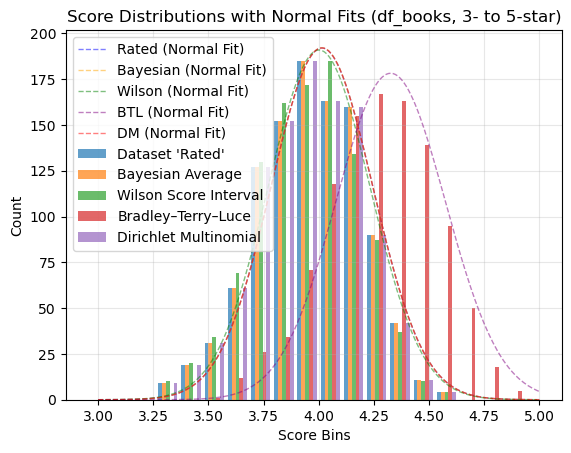

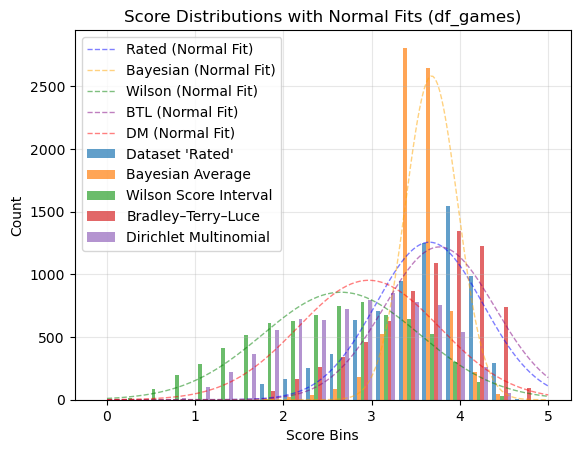

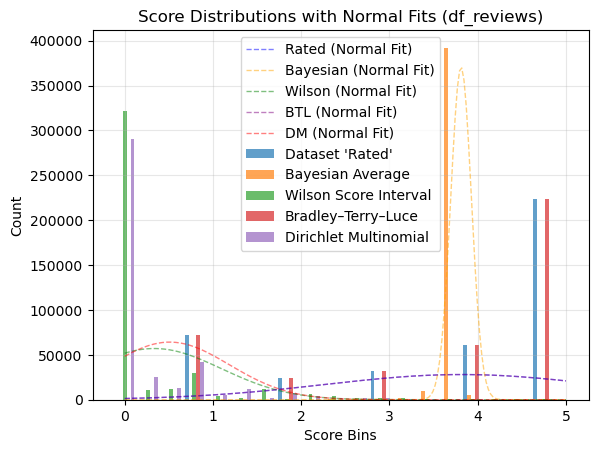

In [53]:
# Constructing a function to create histograms with normal distribution curves (fit).
def make_histogram(df, name, scale1, scale2):
    bins = np.linspace(scale1, scale2, 20)
    width = (bins[1] - bins[0]) / 6
    x = bins[:-1]

    rated_counts, _ = np.histogram(df["Rated"].to_numpy(), bins = bins)
    bayes_counts, _ = np.histogram(df["Bayesian_Score"].to_numpy(), bins = bins)
    wilson_counts, _ = np.histogram(df["Wilson_Score"].to_numpy(), bins = bins)
    btl_counts, _ = np.histogram(df["BTL_Score"].to_numpy(), bins = bins)
    dm_counts, _ = np.histogram(df["DM_Score"].to_numpy(), bins = bins)
        
    plt.bar(x - (2 * width), rated_counts, width = width, label = "Dataset 'Rated'", alpha = 0.7)
    plt.bar(x - (width), bayes_counts, width = width, label = "Bayesian Average", alpha = 0.7)
    plt.bar(x, wilson_counts, width = width, label = "Wilson Score Interval", alpha = 0.7)
    plt.bar(x + (width), btl_counts, width = width, label = "Bradley–Terry–Luce", alpha = 0.7)
    plt.bar(x + (2 * width), dm_counts, width = width, label = "Dirichlet Multinomial", alpha = 0.7)

    xx = np.linspace(scale1, scale2, 200)

    for col, color, label in zip(
        ["Rated", "Bayesian_Score", "Wilson_Score", "BTL_Score", "DM_Score"],
        ["blue", "orange", "green", "purple", "red"],
        ["Rated (Normal Fit)", "Bayesian (Normal Fit)", "Wilson (Normal Fit)", "BTL (Normal Fit)", "DM (Normal Fit)"]
    ):
        data = df[col].to_numpy()
        mu, sigma = np.mean(data), np.std(data)
        if sigma > 0:
            pdf = stats.norm.pdf(xx, mu, sigma)
            pdf_scaled = pdf * len(data) * (bins[1] - bins[0])
            plt.plot(xx, pdf_scaled, color = color, linestyle = "--", linewidth = 1, alpha = 0.5, label = label)

    plt.xlabel("Score Bins")
    plt.ylabel("Count")
    plt.title(f"Score Distributions with Normal Fits ({name})")
    plt.legend()
    plt.grid(True, alpha = 0.3)
    plt.show()

# Apply to each dataset.
make_histogram(df_books, "df_books, 3- to 5-star", 3, 5)
make_histogram(df_games, "df_games", 0, 5)
make_histogram(df_reviews, "df_reviews", 0, 5)

##### Task 7.2: Overlay Histograms

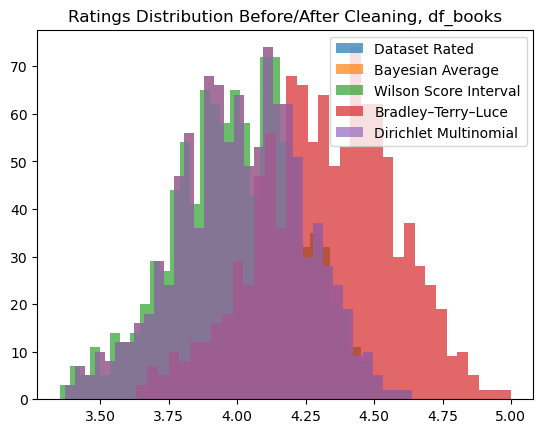

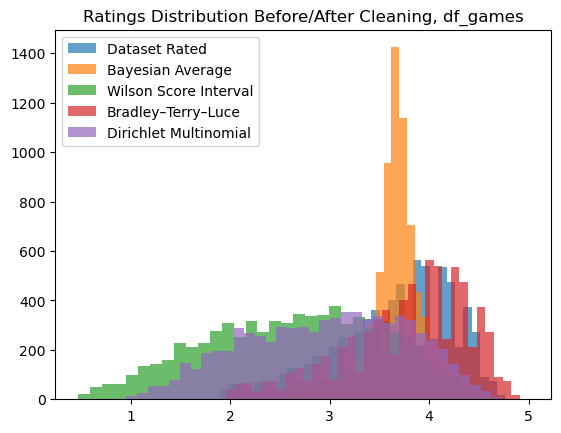

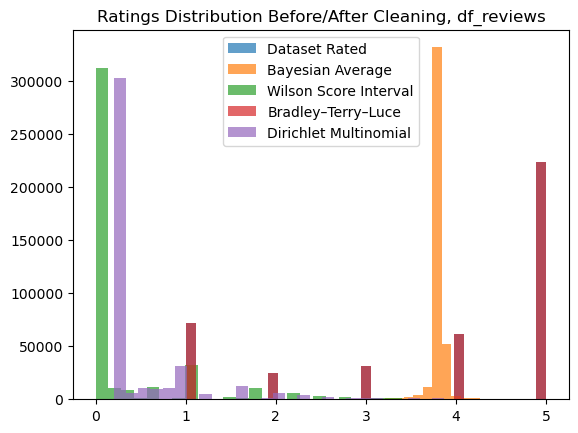

In [55]:
# Constructing a function to create overlay histograms.
def make_overlapping_histogram(df, name):
    plt.title("Ratings Distribution Before/After Cleaning, " + name)
    plt.hist(df["Rated"], bins = 35, alpha = 0.7, label = "Dataset Rated")
    plt.hist(df["Bayesian_Score"], bins = 35, alpha = 0.7, label = "Bayesian Average")
    plt.hist(df["Wilson_Score"], bins = 35, alpha = 0.7, label = "Wilson Score Interval")
    plt.hist(df["BTL_Score"], bins = 35, alpha = 0.7, label = "Bradley–Terry–Luce")
    plt.hist(df["DM_Score"], bins = 35, alpha = 0.7, label = "Dirichlet Multinomial")
    plt.legend()
    plt.show()

# Apply to each dataset.
make_overlapping_histogram(df_books, "df_books")
make_overlapping_histogram(df_games, "df_games")
make_overlapping_histogram(df_reviews, "df_reviews")

### Task 8: Real-World Application

"df" is a 10,001 row, 13 column (3.95 MB) dataset titled "10,000 Data about movies (1915 - 2023)" (data.csv), authored by willian oliveira and acquired via Kaggle. As this dataset has no 'null' or "tbd" values, we will be using it to create a document to present our findings.

In [58]:
# Importing file and renaming columns.
df = pl.read_csv("10,000_Data_about_movies_(1915-2023)_willian_oliveira_Kaggle.csv", columns = ["Movie Name", "Movie Rating", "Votes"])
df = df.rename({"Movie Name": "Identifier", "Movie Rating": "Rated"})

# Displaying the contents of this file.
df.describe()

statistic,Identifier,Rated,Votes
str,str,f64,f64
"""count""","""10000""",10000.0,10000.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,6.72702,92797.375
"""std""",null,0.821264,171650.899899
"""min""","""#Alive""",4.9,10002.0
"""25%""",null,6.1,16854.0
"""50%""",null,6.7,34182.0
"""75%""",null,7.3,91546.0
"""max""","""Çöpçüler Krali""",9.3,2.804443e6


In [59]:
# No 'null' values or mismatch of datatypes - life is good :)

# Briefly remove any outliers and scaling the "Rated" values from 0-10 to 0-5.  
df = detect_outliers(df, "Rated")
df = df.with_columns((pl.col("Rated").cast(pl.Float64) / 2).alias("Rated"))

# Applying the weighted ranking algorithms above.
df = bayesian_avg(df)
df = apply_WSI(df)
df = bradley_terry_luce(df)
df = dirichlet_multinomial(df)
df = my_wrs(df)

# Displaying the contents of this file.
df.head()

Identifier,Rated,Votes,Bayesian_Score,Wilson_Score,BTL_Score,DM_Score,My_WRS
str,f64,i64,f64,f64,f64,f64,f64
"""The Dark Knight""",4.5,2786129,4.49998,4.498236,5.0,4.499992,5.0
"""Schindler's List""",4.5,1409869,4.49996,4.497519,5.0,4.499985,4.770503
"""The Lord of the Rings: The Ret…",4.5,1919908,4.49997,4.497874,5.0,4.499989,4.874538
"""12 Angry Men""",4.5,834248,4.499932,4.496772,5.0,4.499974,4.593712
"""The Godfather Part II""",4.5,1327069,4.499957,4.497442,5.0,4.499984,4.750111


In [60]:
# Now, let's transfer our outcome into a file.
df_rerate = pl.read_csv("10,000_Movies_ReRanked_WRS.csv")

# This file should be included in the repository where you find this project - take a look there!
df_rerate

Identifier,Rated,Votes,Bayesian_Score,Wilson_Score,BTL_Score,DM_Score,My_WRS
str,f64,i64,f64,f64,f64,f64,f64
"""The Shawshank Redemption""",4.65,2804443,4.649977,4.648504,5.0,4.649992,5.0
"""The Godfather""",4.6,1954174,4.599968,4.598094,4.946237,4.599989,4.825889
"""Ramayana: The Legend of Prince…",4.6,12995,4.595261,4.576052,4.946237,4.598308,3.155763
"""The Chaos Class""",4.6,42231,4.598538,4.586871,4.946237,4.599479,3.548397
"""The Dark Knight""",4.5,2786129,4.49998,4.498236,4.83871,4.499992,4.836574
…,…,…,…,…,…,…,…
"""Golmaal Again""",2.45,10183,2.454464,2.40148,2.634409,2.448896,1.637523
"""Not to Forget""",2.45,11191,2.454063,2.403715,2.634409,2.448995,1.65427
"""Housefull 3""",2.45,10308,2.45441,2.401775,2.634409,2.448909,1.639687


### Task 9: Further Discussions

This project demonstrates how naive average ratings can be troublesome and misleading, and how statistical techniques could improve the reliability of even the little choices that we make every single day. So, what can we actually do with what we found in this project?

- **Real-World Deployment**
  - E-Commerce Platforms (Amazon, Shopee): product rating filters.
  - Media/Entertainment (Netflix, IMDB, Steam): recommend content with reliable user ratings.
  - Food Delivery & Services (Grab, Yelp): prevent restaurants with a one 5-star review from topping search results.  

- **Production Strategy**
  - **Backend:** FastAPI or Flask for API endpoints serving weighted ratings.
  - **Frontend:** React or Next.js for dynamic, responsive product listings.
  - **Database:** PostgreSQL or MongoDB to store products, ratings, vote counts.
  - **Cloud Deployment:** AWS or GCP for scalability, low latency, and reliability.
  - **Caching:** Redis for frequently queried top-rated products.

- **Visualization & Testing**
  - Matplotlib for analyzing rating distributions and outlier detection.
  - Streamlit dashboards for rapid prototyping and stakeholder demo.
  - Automated unit testing to validate scoring functions across datasets.

- **Strategic Application**
  - Start with Bayesian Average for production due to simplicity and reliability.
  - Implement Wilson Score Interval for filtering “new items” or low-vote items in search ranking.
  - Use custom/hybrid scores for internal analytics and A/B testing of ranking algorithms.
  - Continuously monitor rating distributions and adjust thresholds dynamically to maintain fairness and stability.

### Task 10: References and Citations

#### Use of Generative AI:  
The functions of the respective weighted rating algorithms (Bayesian Average, Wilson Score Interval, Bradley-Terry-Luce Model, and Dirichlet–Multinomial Model) were generated by ChatGPT (GPT-5 model), adapted and later amended by Melvin to serve applicable and practical for dataset analysis.

#### Used Datasets:  
KARKAVELRAJA J. (2023, March 10). IMDB Top 250 Movies.  
Kaggle. https://www.kaggle.com/datasets/karkavelrajaj/imdb-top-250-movies 

PromptCloud. (2017, January 11). Amazon Reviews: Unlocked Mobile Phones. Kaggle.  
https://www.kaggle.com/datasets/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones 

The Devastator. (2023a, December 6). Books Sales and Ratings. Kaggle.  
https://www.kaggle.com/datasets/thedevastator/books-sales-and-ratings  

The Devastator. (2023b, February 10). Global Video Game Sales & Ratings. Kaggle.  
https://www.kaggle.com/datasets/thedevastator/global-video-game-sales-ratings?select=Cleaned%2BData%2B2.csv  